In [ ]:
import pypsa 
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt


INFO:pypsa.network.io:Imported network 'PyPSA-Eur (osm vlatest)' has buses, carriers, lines, links, shapes, transformers


{'nodes': {'Bus': <matplotlib.collections.PatchCollection at 0x1b30ee5b830>},
 'branches': {'Link': <matplotlib.collections.LineCollection at 0x1b30ee8f4d0>,
  'Line': <matplotlib.collections.LineCollection at 0x1b30eeb58b0>,
  'Transformer': <matplotlib.collections.LineCollection at 0x1b30ee8f9e0>},
 'flows': {}}

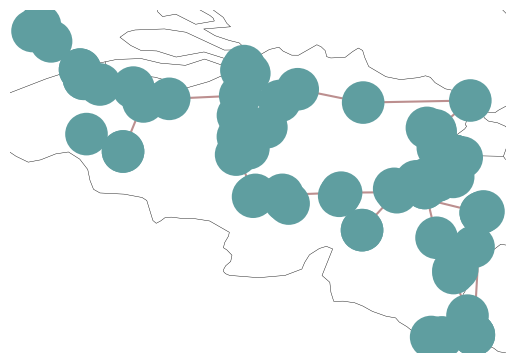

In [ ]:
# load network
#n = pypsa.Network("../data/networks/base.nc") # base has only lines, transformers and branches
# n = pypsa.Network("../data/networks/elec_s_256_ec.nc")
# n = pypsa.Network("../data/networks/elec.nc")
# n = pypsa.Network("../pypsa-eur/results/test-elec/networks/base_s_6_elec_.nc")
n = pypsa.Network("../pypsa-eur/resources/test-elec/networks/base.nc")
# plot network
n.plot()

There are some problems with the networks from zenodo, because they were generated with pypsa 0.15. 
The networks that were generated ourselves are pypsa v1.0. So there are some differences in the exnaming 

In [ ]:
# in pypsa-eur hydro reservoirs are not modelled as generators but as storage units
#print(n.storage_units[n.storage_units["carrier"] == "hydro"].info()) # for pypsa 0.15 .nc files

print(n.storage_units.info())
# HydroStorage_CSV = n.storage_units[n.storage_units["carrier"] == "hydro"].to_csv("../results/sandbox_hydro_storage_units.csv")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   bus                                 0 non-null      object 
 1   control                             0 non-null      object 
 2   type                                0 non-null      object 
 3   p_nom                               0 non-null      float64
 4   p_nom_mod                           0 non-null      float64
 5   p_nom_extendable                    0 non-null      bool   
 6   p_nom_min                           0 non-null      float64
 7   p_nom_max                           0 non-null      float64
 8   p_nom_set                           0 non-null      float64
 9   p_min_pu                            0 non-null      float64
 10  p_max_pu                            0 non-null      float64
 11  p_set                               0 non-null      float

In [ ]:
print(n.storage_units.carrier)

Series([], Name: carrier, dtype: object)


In [ ]:
print(n.generators.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 38 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bus                      0 non-null      object 
 1   control                  0 non-null      object 
 2   type                     0 non-null      object 
 3   p_nom                    0 non-null      float64
 4   p_nom_mod                0 non-null      float64
 5   p_nom_extendable         0 non-null      bool   
 6   p_nom_min                0 non-null      float64
 7   p_nom_max                0 non-null      float64
 8   p_nom_set                0 non-null      float64
 9   p_min_pu                 0 non-null      float64
 10  p_max_pu                 0 non-null      float64
 11  p_set                    0 non-null      float64
 12  e_sum_min                0 non-null      float64
 13  e_sum_max                0 non-null      float64
 14  q_set                    0 non-null   

In [ ]:
print(n.generators.carrier)

Series([], Name: carrier, dtype: object)


In [ ]:
print(n.generators[n.generators["carrier"] == "ror"]) # for pypsa 0.15 .nc files
# print(n.storage_units)

Empty DataFrame
Columns: [bus, control, type, p_nom, p_nom_mod, p_nom_extendable, p_nom_min, p_nom_max, p_nom_set, p_min_pu, p_max_pu, p_set, e_sum_min, e_sum_max, q_set, sign, carrier, marginal_cost, marginal_cost_quadratic, active, build_year, lifetime, capital_cost, efficiency, committable, start_up_cost, shut_down_cost, stand_by_cost, min_up_time, min_down_time, up_time_before, down_time_before, ramp_limit_up, ramp_limit_down, ramp_limit_start_up, ramp_limit_shut_down, weight, p_nom_opt]
Index: []

[0 rows x 38 columns]


In [ ]:
print(n.generators)

Empty DataFrame
Columns: [bus, control, type, p_nom, p_nom_mod, p_nom_extendable, p_nom_min, p_nom_max, p_nom_set, p_min_pu, p_max_pu, p_set, e_sum_min, e_sum_max, q_set, sign, carrier, marginal_cost, marginal_cost_quadratic, active, build_year, lifetime, capital_cost, efficiency, committable, start_up_cost, shut_down_cost, stand_by_cost, min_up_time, min_down_time, up_time_before, down_time_before, ramp_limit_up, ramp_limit_down, ramp_limit_start_up, ramp_limit_shut_down, weight, p_nom_opt]
Index: []

[0 rows x 38 columns]


In [ ]:
print(n.lines.info())

<class 'pandas.core.frame.DataFrame'>
Index: 73 entries, merged_way/114984936-380+4 to way/98411324-380
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bus0                73 non-null     object 
 1   bus1                73 non-null     object 
 2   type                73 non-null     object 
 3   x                   73 non-null     float64
 4   r                   73 non-null     float64
 5   g                   73 non-null     float64
 6   b                   73 non-null     float64
 7   s_nom               73 non-null     float64
 8   s_nom_mod           73 non-null     float64
 9   s_nom_extendable    73 non-null     bool   
 10  s_nom_min           73 non-null     float64
 11  s_nom_max           73 non-null     float64
 12  s_nom_set           0 non-null      float64
 13  s_max_pu            73 non-null     float64
 14  capital_cost        73 non-null     float64
 15  active              73 no